<div class="alert alert-block alert-info">
    
These blue boxes contain instructions for you to follow, or stuff for you to do
<h2>How to access this Jupyter notebook</h2>

* <b>Step 1</b>: Open a web browser,  and go to [this page](https://jupyter.warwick.ac.uk/module/CH274), 
* <b>Step 2</b>: Enter your SCRTP username and password and press the "Start Server" button.<br>
* <b>Step 3</b>: Wait (it could take a few minutes) until the blue box says "Jupyter notebook server running!". At that point, click on the weblink below said message.<br>
* <b>Step 4</b>: Select the Jupyter Notebook you want to work on. <i>Remember to make a copy of the orginal notebook</i> (which is read-only). To do so, in the toolbar on top of the notebook, select File and then Make a Copy <br>
* <b>Step 5</b>: You're all set! <br>
* <b>Step 6</b>: <font color="red">When you are done, remember to click the "Stop Server" button in the launcher web browser tab.</font> Please do, it's really quite important. <br>
<b> Remember: </b> You can access your copy of the Notebook at any time from any device off and on campus by going through the same steps on e.g. your laptop - all the changes you have made will be saved and synced! <br>

<div/>

In [2]:
import fileinput
import re
import glob

def grep(PAT, FILES):
    for line in fileinput.input(glob.glob(FILES)):
        if re.search(PAT, line):
            print(fileinput.filename(), fileinput.lineno(), line)

In [3]:
#Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import psi4
import ase
from ase.build import molecule
from ase.atoms import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from psi4_helper import geom_ase_to_psi4

# Excited states of NaI

In the second part of this exercise, the focus will be on excited states. Excited states play a significant role in photochemistry. As you have heard in the previous tutorial, calculation of excited states and their properties requires different methods than for the ground state chemistry. For the excited states, the approximation of only one Slater determinant is usually not valid. Unlike Hartree-Fock, multiconfigurational methods do not restrict the wavefunction to a single Slater determinant, but allow it to be a priori a linear combination of multiple Slater determinants.
On the other hand, a handful of methods usually referred to single-configurational methods, such as TD-DFT can be used to compute the excited-state properties without calculating the excited state wavefunction explicitly. They are faster and easier to use than multiconfigurational methods, but their accuracy may be inferior.

In this exercise we will calculate the excitation energies of the dissociation curve of the sodium iodide (NaI).
This system has been studied via pump-probe spectroscopy by Ahmed Zewail, who received the Nobel Prize for his work in 1999 (J. Chem. Phys. 91, 7415 (1989), doi: 10.1063/1.457266). You will see that the ground state and the first excited singlet state will form an avoided crossing. We will investigate this reaction with TDDFT and CASSCF.


</div>
<img src="NaI2.png" width="350"/>
</div>
<p> Potential energy curves of NaI (Fig. 2 in Ref. 4).</p>


#### Get the geometries

In [4]:
# we set the positions to 0 for atom 0 and to 0.5-4.0 for atom 2
all_atoms = []
nsteps=10
positions=np.zeros((2,3))
atomtype = ["Na","I"]
dr=(4-2)/nsteps
all_distances = np.zeros((nsteps,1))
for i in range(nsteps):
    positions[1,2]=2+i*dr
    all_distances[i]=2+i*dr
    atoms = ase.atoms.Atoms(atomtype,positions)
    all_atoms.append(atoms)
#print(all_atoms[1].positions,all_atoms[2].positions)


### TDDFT calculation of the excited states

In [5]:
from psi4.driver.procrouting.response.scf_response import tdscf_excitations


NaI has 64 electrons
if we want to describe only the $\sigma$ and $\sigma^\ast$ orbitals, then we need 2 electrons in 2 orbitals.
Hence we have:
* 62 electrons sit in 31 orbitals that are doubly occupied and inactive
* orbital number 63 and 64 are active and contain all possible configurations of that 2 electrons can form (how many are these?)
* orbitals above 65 are inactive and unoccupied.

In [10]:
#casscf test
import psi4
psi4.core.clean_options()

nai = psi4.geometry("""0 1
Na        0.000000    0.0   0.0
I      -0.000000   -0.0   1.5 
symmetry c1
""")
n_states = 3
psi4.set_options({
    'basis': 'sto-3g',
    'reference': 'rhf',
    'scf_type':'pk',
    'mcscf_algorithm':'ah',
    'qc_module': 'detci',
    'nat_orbs': True,
        'num_roots':3,
    'frozen_docc': [31],
    'active': [2]
})
energies = np.zeros((nsteps,n_states)) 
for step in range(nsteps):
    geom_input = geom_ase_to_psi4(all_atoms[step], charge=0, multiplicity=1)
    psi4.core.set_output_file("NaI%i.out"%step)

    #initiate Psi4 molecule object
    h2 = psi4.geometry(geom_input)

    casscf_energy, wfn = psi4.energy('casscf', return_wfn=True)
    print(casscf_energy)
    energy = grep("MCSCF Root","NaI%i.out"%step)
    energies[step]=energy

    

-7010.515950513774
NaI0.out 349     MCSCF Root 0 energy =  -7010.515950513774442

NaI0.out 365     MCSCF Root 1 energy =  -7009.776952022897603

NaI0.out 381     MCSCF Root 2 energy =  -7008.887502002478868



TypeError: 'NoneType' object is not subscriptable

In [5]:
import psi4
#psi4.core.clean_options()
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
psi4.core.clean()
psi4.core.set_output_file("moxy.out")
psi4.core.set_num_threads(4)

h2o2 = psi4.geometry("""0 1
O        0.000000    0.695000   -0.092486
O       -0.000000   -0.695000   -0.092486
H       -0.388142    0.895249    0.739888
H        0.388142   -0.895249    0.739888""", name="H2O2")
psi4.set_options({
    "save_jk": True,
    
})

e, wfn = psi4.energy("PBE0/cc-pVDZ", return_wfn=True, molecule=h2o2)
print(e)
res = tdscf_excitations(wfn, states=100)
print(res)

-151.38223159012819
[]


In [34]:
%less moxy.out

In [19]:
for k, v in res[0].items():
    print(f"{k} = {v}")

IndexError: list index out of range

In [14]:
plt.plot(all_distances,all_energies,label = "RHF")
plt.legend()

NameError: name 'all_energies' is not defined

### Compare to UHF

ICH WOLLTE AUCH OPEN SHELL UND CLOSED SHELL VERGLEICHEN ABER PSI4 MACHT GENAU DAS GLEICHE BEI RHF UND UHF?

In [75]:
psi4.core.clean()
#psi4.core.reopen_outfile()
psi4.core.set_output_file('output.dat', False)
psi4.set_memory('1000 MB')
all_energies_uhf = []
##set geometry
#transform ase geometries to Psi4 input string
for i in range(nsteps):
    geom_input = geom_ase_to_psi4(all_atoms[i], charge=0, multiplicity=1)
    #initiate Psi4 molecule object
    h2 = psi4.geometry(geom_input)

    # Set computation options
    psi4.set_options({'basis': '3-21G',
                  'reference': 'uhf',
                      'scf_type':'direct',
                  'e_convergence': 1e-10})

    E, wvf = psi4.energy('scf',return_wfn=True)
    all_energies_uhf.append(E)
    #print('Total HF energy is {0} Hartree \n '.format(E))


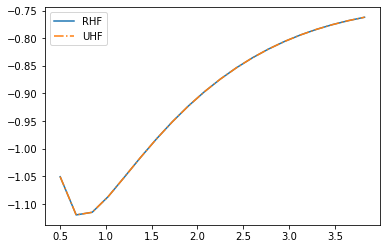

In [77]:
plt.plot(all_distances,all_energies,label = "RHF")
plt.plot(all_distances,all_energies_uhf,label = "UHF",linestyle="-.")
plt.legend()

## Let's see if MP2 can give a better result

In [60]:
all_energies_mp2 = []
for i in range(nsteps):
    #print("Do calculations for MP2 step %i"%i)
    geom_input = geom_ase_to_psi4(all_atoms[i], charge=0, multiplicity=1)
    #initiate Psi4 molecule object
    h2 = psi4.geometry(geom_input)

    # Set computation options
    psi4.set_options({'basis': '3-21G',
                  'reference': 'uhf',
                  'scf_type':'direct',
                    'e_convergence':1e-8})
    E, wvf = psi4.energy('mp2',return_wfn=True)
    all_energies_mp2.append(E)
    #print('Total HF energy is {0} Hartree \n '.format(E))


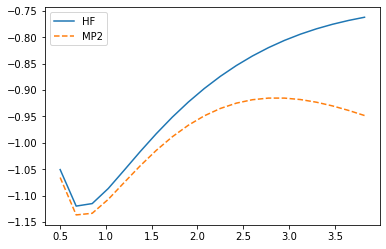

In [61]:
plt.plot(all_distances,all_energies,label="HF")
plt.plot(all_distances,all_energies_mp2,label="MP2",linestyle="--")
plt.legend()

## Questions
As you can see, HF differs strongly from MP2. 
Further, you can see that the MP2-dissociation curve decreases in energy at large distances. Do you expect this behaviour?

## Group Work: Dissociation curve of H$_2$

First, we are going to calculate the dissociation curve of the beryllium dimer with different methods. Therefore, each of you will get a different method. In the end, we will compare the different results and investigate the differences of each method.

The methods that should be tested are:
* HF
* MP2
* DFT/PBE
* DFT/PBE0
* DFT/LDA
* CASSCF(2,2)
* CCSD



With each method the basis set convergence should be investigated. Therefore, plot the dissociation curves between a bond length of 0.5 to 4.0 Angstrom with a double-zeta, triple-zeta basis set and a higher-accurate basis set of your choice.
Plot the results and let us know whenever you are finished.

## References
1. [[Szabo:1996](http://store.doverpublications.com/0486691861.html)] A. Szabo and N. S. Ostlund, *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. Courier Corporation, 1996.
2. [[Levine:2000](https://books.google.com/books?id=80RpQgAACAAJ&dq=levine%20quantum%20chemistry%205th%20edition&source=gbs_book_other_versions)] I. N. Levine, *Quantum Chemistry*. Prentice-Hall, New Jersey, 5th edition, 2000.
3. [[Helgaker:2000](https://books.google.com/books?id=lNVLBAAAQBAJ&pg=PT1067&dq=helgaker+molecular+electronic+structure+theory&hl=en&sa=X&ved=0ahUKEwj37I7MkofUAhWG5SYKHaoPAAkQ6AEIKDAA#v=onepage&q=helgaker%20molecular%20electronic%20structure%20theory&f=false)] T. Helgaker, P. Jorgensen, and J. Olsen, *Molecular Electronic Structure Theory*, John Wiley & Sons Inc, 2000.
4. J. Chem. Phys. 91, 7415 (1989), doi: 10.1063/1.457266